In [1]:
#!/usr/bin/env python
#-*- coding: utf-8 -*-
'''
    python ==> 비주얼컴퓨팅, 프로젝트4 얼굴 사진 55x40 데이터를 700장 사용해 Deep Neural Network를 사용함으로써 예측모델을 만들어본 코드
                             500번 반복하니 96% 정도의 예측율을 보여준다 굳굳
'''
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.misc
import scipy.io
import random

In [5]:
#-----------------------------------------------------------------
# train
train_images = []
tlabels = []

# train Image 데이터 700장을 불러온다
for num in range(1,701):
    train_images.append(scipy.misc.imread('D:\\edward\\visualComputing_faceDetection\\train_image\\train_'+ str(num)+'.bmp'))

# train Label 데이터를 불러온다
with open("D:\\edward\\visualComputing_faceDetection\\train_label.txt") as f:
    line = [line.rstrip() for line in f]
    tlabels.append(line)

# Image 데이터와 Label 데이터를 numpy 데이터로 수정한다
train_images = np.array(train_images)
# LBP 연산을 위해 train_images2 선언해준다
train_images2 = np.array(train_images)
train_images = train_images.reshape(700, 2200, )


tlabels = np.array(tlabels)     # tlabels = (1,700)
tlabels = tlabels.reshape(700,1)

# train Label 데이터를 [1 x 100] 의 행렬로 표현한다
#           예를 들어 3이면 [0,0,1,0,.....,0] 과 같이 설정한다
train_labels  = np.array(np.zeros(70000).reshape(700,100))
for num in range(0,700):
    train_labels[num][int(tlabels[num][0]) - 1] = 1



#-----------------------------------------------------------------
# test
test_images = []
testlabels = []


# test Image 데이터 700장을 불러온다
for num in range(1,701):
    test_images.append(scipy.misc.imread('D:\\edward\\visualComputing_faceDetection\\test_image\\test_'+ str(num)+'.bmp'))


# test Label 데이터를 불러온다
with open("D:\\edward\\visualComputing_faceDetection\\test_label.txt") as f:
    line = [line.rstrip() for line in f]
    testlabels.append(line)

# Image 데이터와 Label 데이터를 numpy 데이터로 수정한다
test_images = np.array(test_images)
# LBP 연산을 위해 test_images2 선언해준다
test_images2 = np.array(test_images)
test_images = test_images.reshape(700, 2200, )

testlabels = np.array(testlabels)     # tlabels = (1,700)
testlabels = testlabels.reshape(700,1)

# train Label 데이터를 [1 x 100] 의 행렬로 표현한다
#           예를 들어 3이면 [0,0,1,0,.....,0] 과 같이 설정한다
test_labels  = np.array(np.zeros(70000).reshape(700,100))
for num in range(0,700):
    test_labels[num][int(testlabels[num][0]) - 1] = 1


# 중요! Image 데이터들은 0~255 사이의 값이므로 255로 나눠주면서 정규화를 한다. 학습이 매우 잘된다
train_images = train_images / 255.
test_images =  test_images / 255.


In [6]:
#-----------------------------------------------------------------

_num_examples = 700   # 데이터 갯수
_index_in_epoch = 0   # epoch
_images = train_images  # Image 변수 
_labels = train_labels  # Label 변수
_epochs_completed = 0   

# batch 연산을 수행하는 함수
# 호출될 때마다 랜덤으로 batch_size의 (Image, Label) 데이터를 반환한다
def next_batch(batch_size):
    """Return the next `batch_size` examples from this data set."""
    global _index_in_epoch
    global _images
    global _labels
    global _epochs_completed

    start = _index_in_epoch
    _index_in_epoch += batch_size

    if _index_in_epoch > _num_examples:
      # Finished epoch
      _epochs_completed += 1

      # Shuffle the data
      perm = np.arange(_num_examples)
      np.random.shuffle(perm)
      _images = _images[perm]
      _labels = _labels[perm]

      # Start next epoch
      start = 0
      _index_in_epoch = batch_size
      assert batch_size <= _num_examples

    end = _index_in_epoch
    return _images[start:end], _labels[start:end]


# 가중치를 초기화하는 함수 (정규분포 stddev=0.1로 초기화한다)
def weight_variable(shape):
	initial = tf.truncated_normal(shape, stddev=0.1)
	return tf.Variable(initial)


# 바이어스를 초기화하는 함수 (0.1로 초기화한다)
def bias_variable(shape):
	initial = tf.constant(0.1, shape=shape)
	return tf.Variable(initial)


# 컨벌루션을 실행하는 함수
# padding = 'SAME' 입력과 출력의 이미지 크기가 같도록 해준다
# (28,28) --> (28,28)
# padding = 'VALID' 필터의 크기만큼 이미지 크기가 감소한다
def conv2d_valid(x, W):
	return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='VALID')


def conv2d_same(x, W):
	return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')


# max pooling을 실행하는 함수
def max_pool_2x2(x):
	return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


In [7]:
#-----------------------------------------------------------------
# Tensorflow 코드
#-----------------------------------------------------------------

x = tf.placeholder("float32", [None, 2200]) # mnist data image of shape 55 x 40 = 2200
y = tf.placeholder("float32", [None, 100]) 

W = tf.Variable(tf.zeros([2200,100]))
b = tf.Variable(tf.zeros([100]))


# 1st conv layer ----------------------
W_conv1 = weight_variable([8,5,1,32])
b_conv1 = bias_variable([32])

# -1 : 아직 디멘젼이 결정되지 않았다
# 1 : 흑백이므로 1을 삽입한다. 칼라이면 3을 삽입한다
# x은 2200x1인데 55x40x1로 행렬을 다시 만들어준다
x_image = tf.reshape(x, [-1, 55, 40, 1])

# y = x*w + b에 ReLU를 적용한다
# (55,40) ==> (48,36)
h_conv1 = tf.nn.relu(conv2d_valid(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
# (48,36) ==> (24, 18)



# 2nd conv layer -----------------------
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

# (24, 18) ==> (24, 18)
h_conv2 = tf.nn.relu(conv2d_same(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
# (24, 18) ==> (12, 9)



# 1st fully connected layer -----------------------
W_fc1 = weight_variable([12*9*64, 3000])
b_fc1 = bias_variable([3000])

h_pool2_flat = tf.reshape(h_pool2, [-1, 12*9*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
# 위 연산으로 1024x1의 벡터가 생성된다



# Dropout ------------------------
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)



# 2nd fully connected layer --------------
W_fc2 = weight_variable([3000, 100])
b_fc2 = bias_variable([100])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


In [8]:
# learning_rate 잘 설정하는게 중요하다.. 0.1로 하니 전혀 변화가 없었다
learning_rate = 1e-4


cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


# 정답률을 계산한다  y_conv  vs  y
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



In [9]:
#----------------------------------------------
batch_size = 50      # 한 루프에 몇개의 (Image, Label) 데이터를 학습하는지 설정
display_step = 200    # 루프를 돌면서 화면에 표시할 빈도 설정

for i in range(5000):
	costVal = 0.
	batch = next_batch(batch_size)
	# 20번 돌릴 때마다 결과를 확인한다
	if i % display_step == 0:
		train_accuracy = sess.run(accuracy,feed_dict={x:batch[0], y:batch[1], keep_prob:1.0})
		costVal = sess.run(cost, feed_dict={x: batch[0], y: batch[1], keep_prob:1.0})
    
		print('step', i , 'training_accuracy', train_accuracy,'cost', costVal)
        
        # 실제 학습과정 함수, dropout 50%를 토대로 학습한다
	sess.run(optimizer,feed_dict={x:batch[0],y:batch[1], keep_prob:0.5})


step 0 training_accuracy 0.0 cost 48.7996
step 200 training_accuracy 0.66 cost 2.08699
step 400 training_accuracy 1.0 cost 0.476292
step 600 training_accuracy 1.0 cost 0.110921
step 800 training_accuracy 1.0 cost 0.0185977
step 1000 training_accuracy 1.0 cost 0.00748023
step 1200 training_accuracy 1.0 cost 0.00504374
step 1400 training_accuracy 1.0 cost 0.00210127
step 1600 training_accuracy 1.0 cost 0.00101403
step 1800 training_accuracy 1.0 cost 0.00135841
step 2000 training_accuracy 1.0 cost 0.000515793
step 2200 training_accuracy 1.0 cost 0.000594515
step 2400 training_accuracy 1.0 cost 0.000271415
step 2600 training_accuracy 1.0 cost 0.000249182
step 2800 training_accuracy 1.0 cost 0.000133631
step 3000 training_accuracy 1.0 cost 0.000218105
step 3200 training_accuracy 1.0 cost 0.000257929
step 3400 training_accuracy 1.0 cost 0.000186129
step 3600 training_accuracy 1.0 cost 0.000156285
step 3800 training_accuracy 1.0 cost 4.63163e-05
step 4000 training_accuracy 1.0 cost 0.00011750

In [8]:
# 전부 학습이 끝나면 테스트 데이터를 넣어 정확도를 계산한다
test_accuracy = sess.run(accuracy,feed_dict={x: test_images, y: test_labels, keep_prob: 1.0})
print('test accuracy', test_accuracy)


test accuracy 0.992857


Label:  [23]
Prediction:  [23]


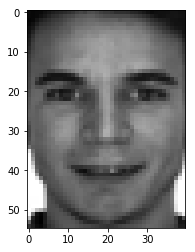

In [16]:
#----------------------------------------------
# 임의의 얼굴 하나를 출력한 다음 맞혀보는 코드 
r = random.randint(0, _num_examples -1)
print ("Label: ", sess.run(tf.argmax(test_labels[r:r+1], 1)))
print ("Prediction: ", sess.run(tf.argmax(y_conv, 1), {x:test_images[r:r+1], keep_prob:1.0}))

plt.imshow(test_images[r:r+1].reshape(55, 40), cmap='gray', interpolation='nearest')
plt.show()